In [ ]:
# ================================================================
# 💫 Emotion Classification with DeBERTa-v3-base + Focal Loss + Class Weights
# ================================================================

!pip install transformers datasets scikit-learn accelerate -q

import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
from datasets import Dataset
from transformers import (
    AutoTokenizer,
    AutoModelForSequenceClassification,
    TrainingArguments,
    Trainer
)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# ================================================================
# 1️⃣ Load Dataset
# ================================================================
df = pd.read_csv("/content/balanced_emotion_dataset.csv")
print(f"✅ Loaded {len(df)} samples with columns: {list(df.columns)}")

# Encode labels
le = LabelEncoder()
df["label"] = le.fit_transform(df["emotion"])
num_labels = len(le.classes_)
print(f"✅ Detected {num_labels} emotion classes: {list(le.classes_)}")

# Train/validation split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    df["text"].tolist(),
    df["label"].tolist(),
    test_size=0.2,
    random_state=42,
    stratify=df["label"]
)

# ================================================================
# 2️⃣ Tokenization
# ================================================================
MODEL_NAME = "microsoft/deberta-v3-base"
tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=128)
val_encodings   = tokenizer(val_texts,   truncation=True, padding=True, max_length=128)

train_dataset = Dataset.from_dict({
    "input_ids": train_encodings["input_ids"],
    "attention_mask": train_encodings["attention_mask"],
    "labels": train_labels
})
val_dataset = Dataset.from_dict({
    "input_ids": val_encodings["input_ids"],
    "attention_mask": val_encodings["attention_mask"],
    "labels": val_labels
})

# ================================================================
# 3️⃣ Compute Class Weights
# ================================================================
class_weights = compute_class_weight(
    class_weight="balanced",
    classes=np.unique(df["label"]),
    y=df["label"]
)
class_weights = torch.tensor(class_weights, dtype=torch.float)
print("📊 Class Weights:", class_weights)

# ================================================================
# 4️⃣ Define Focal Loss (with Class Weights)
# ================================================================
class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2, reduction="mean"):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, logits, targets):
        ce_loss = F.cross_entropy(logits, targets, weight=self.alpha, reduction="none")
        pt = torch.exp(-ce_loss)
        focal_loss = ((1 - pt) ** self.gamma) * ce_loss

        if self.reduction == "mean":
            return focal_loss.mean()
        elif self.reduction == "sum":
            return focal_loss.sum()
        else:
            return focal_loss

# ================================================================
# 5️⃣ Custom Trainer with Focal Loss
# ================================================================
class FocalTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, **kwargs):
        """
        Custom loss computation for Hugging Face Trainer.
        Supports new trainer API (num_items_in_batch argument).
        """
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits  = outputs.get("logits")

        # Apply Focal Loss with class weights
        loss_fct = FocalLoss(alpha=class_weights.to(model.device), gamma=2)
        loss = loss_fct(logits, labels)

        return (loss, outputs) if return_outputs else loss
# ================================================================
# 6️⃣ Model + Training Arguments
# ================================================================
model = AutoModelForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_labels
)

training_args = TrainingArguments(
    output_dir="/content/deberta_v3_focal_model",
    eval_strategy="epoch",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=4,
    weight_decay=0.01,
    warmup_ratio=0.1,
    lr_scheduler_type="cosine",
    logging_dir="/content/logs",
    logging_steps=100,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    report_to="none"
)

# ================================================================
# 7️⃣ Metrics Function
# ================================================================
def compute_metrics(pred):
    labels = pred.label_ids
    preds = np.argmax(pred.predictions, axis=1)
    acc = accuracy_score(labels, preds)
    prec, recall, f1, _ = precision_recall_fscore_support(labels, preds, average="weighted")
    return {"accuracy": acc, "precision": prec, "recall": recall, "f1": f1}

# ================================================================
# 8️⃣ Train
# ================================================================
trainer = FocalTrainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

trainer.train()

# ================================================================
# 9️⃣ Save Model + Tokenizer + Label Encoder
# ================================================================
save_dir = "/content/final_deberta_v3_focal"
model.save_pretrained(save_dir)
tokenizer.save_pretrained(save_dir)

import pickle
with open(f"{save_dir}/label_encoder.pkl", "wb") as f:
    pickle.dump(le, f)

print(f"\n✅ Final model saved at: {save_dir}")



✅ Loaded 169845 samples with columns: ['emotion', 'text']
✅ Detected 7 emotion classes: ['anger', 'fear', 'joy', 'love', 'neutral', 'sadness', 'surprise']


/usr/local/lib/python3.12/dist-packages/transformers/convert_slow_tokenizer.py:564: UserWarning: The sentencepiece tokenizer that you are converting to a fast tokenizer uses the byte fallback option which is not implemented in the fast tokenizers. In practice this means that the fast version of the tokenizer can produce unknown tokens whereas the sentencepiece version would have converted these unknown tokens into a sequence of byte tokens matching the original piece of text.
  warnings.warn(


📊 Class Weights: tensor([1.2132, 0.9730, 0.9744, 0.8329, 0.9697, 1.1636, 0.9705])


Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/tmp/ipython-input-2933269712.py:155: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `FocalTrainer.__init__`. Use `processing_class` instead.
  trainer = FocalTrainer(
The tokenizer has new PAD/BOS/EOS tokens that differ from the model config and generation config. The model config and generation config were aligned accordingly, being updated with the tokenizer's values. Updated tokens: {'eos_token_id': 2, 'bos_token_id': 1}.


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.554100,0.496918,0.722335,0.737388,0.722335,0.724157
2,0.360100,0.409426,0.768701,0.779806,0.768701,0.768847
3,0.236900,0.395747,0.805617,0.808088,0.805617,0.805599


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,0.554100,0.496918,0.722335,0.737388,0.722335,0.724157
2,0.360100,0.409426,0.768701,0.779806,0.768701,0.768847
3,0.236900,0.395747,0.805617,0.808088,0.805617,0.805599
4,0.191900,0.450746,0.812123,0.813411,0.812123,0.812212



✅ Final model saved at: /content/final_deberta_v3_focal


In [17]:
from google.colab import drive
import shutil, os

# Mount Drive
drive.mount('/content/drive')

# Define source and destination paths
src_folders = [
    "/content/final_deberta_v3_focal",
    "/content/deberta_v3_focal_model"
]

dest_base = "/content/drive/MyDrive/Emotion_Models"

# Create destination directory if not exists
os.makedirs(dest_base, exist_ok=True)

# Copy each folder safely
for src in src_folders:
    folder_name = os.path.basename(src.rstrip('/'))
    dest = os.path.join(dest_base, folder_name)
    print(f"📦 Copying {src} → {dest} ...")
    shutil.copytree(src, dest, dirs_exist_ok=True)
    print(f"✅ Saved: {dest}\n")

print("🎯 All model folders successfully saved to Google Drive!")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📦 Copying /content/final_deberta_v3_focal → /content/drive/MyDrive/Emotion_Models/final_deberta_v3_focal ...
✅ Saved: /content/drive/MyDrive/Emotion_Models/final_deberta_v3_focal

📦 Copying /content/deberta_v3_focal_model → /content/drive/MyDrive/Emotion_Models/deberta_v3_focal_model ...
✅ Saved: /content/drive/MyDrive/Emotion_Models/deberta_v3_focal_model

🎯 All model folders successfully saved to Google Drive!



📈 Evaluating model on validation set...



📈 Validation Metrics:
eval_loss           : 0.4507
eval_accuracy       : 0.8121
eval_precision      : 0.8134
eval_recall         : 0.8121
eval_f1             : 0.8122
eval_runtime        : 198.6728
eval_samples_per_second: 170.9800
eval_steps_per_second: 21.3770
epoch               : 4.0000

⏱ Evaluation Time: 3.31 minutes

📋 Classification Report:
               precision    recall  f1-score   support

       anger      0.796     0.806     0.801      4000
        fear      0.868     0.886     0.877      4988
         joy      0.759     0.826     0.791      4980
        love      0.776     0.776     0.776      5826
     neutral      0.850     0.792     0.820      5004
     sadness      0.801     0.821     0.811      4171
    surprise      0.844     0.784     0.813      5000

    accuracy                          0.812     33969
   macro avg      0.813     0.813     0.813     33969
weighted avg      0.813     0.812     0.812     33969



NameError: name 'SAVE_FOLDER' is not defined

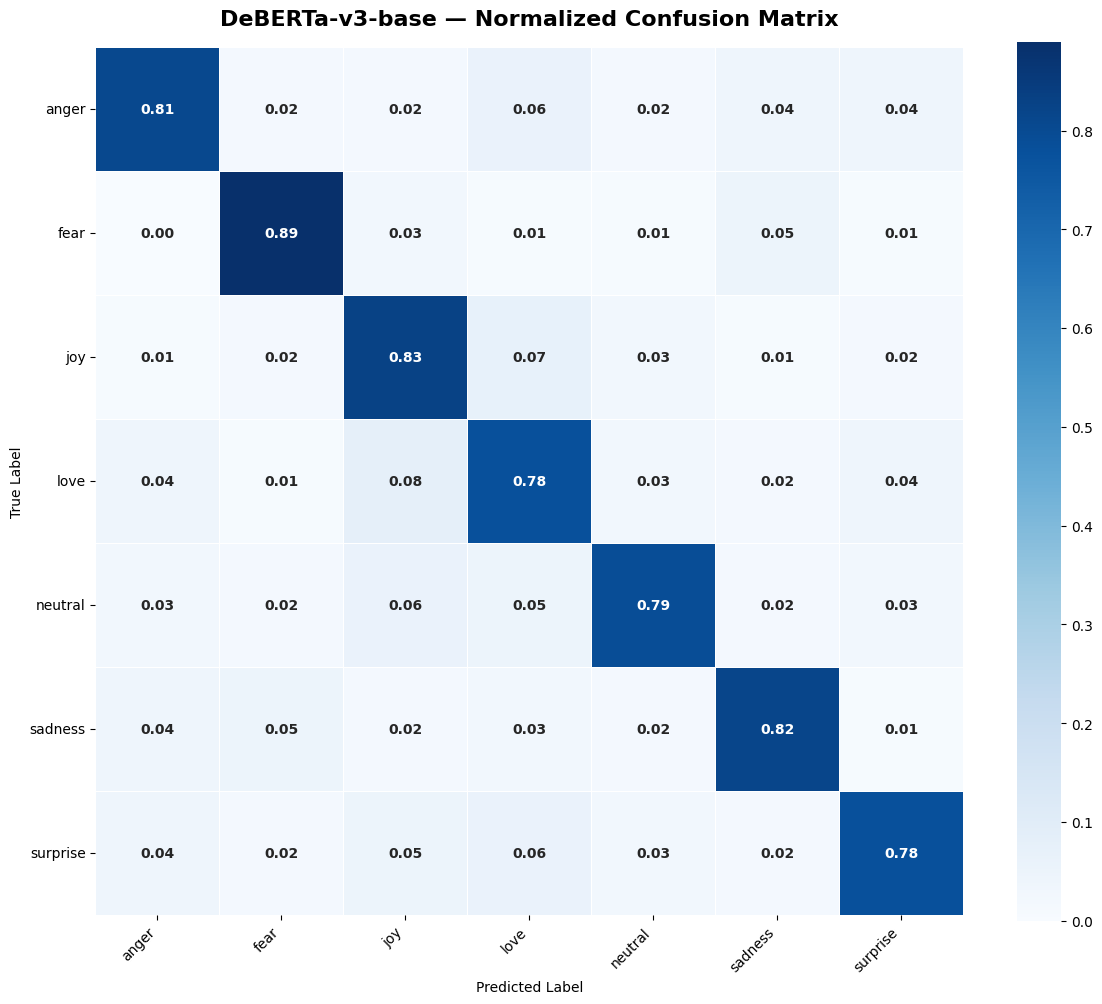

In [18]:
# ================================================================
# 💫 Post-Training Evaluation, Visualization & Drive Save (Fixed)
# ================================================================

import pandas as pd, numpy as np, os, time, pickle, json
import matplotlib.pyplot as plt, seaborn as sns
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix
)

# Start timer for evaluation
start = time.time()

# 1️⃣ Evaluate validation set and collect metrics
print("\n📈 Evaluating model on validation set...")
metrics = trainer.evaluate(eval_dataset=val_dataset)

print("\n📈 Validation Metrics:")
for k, v in metrics.items():
    print(f"{k:20s}: {v:.4f}")

print(f"\n⏱ Evaluation Time: {(time.time() - start)/60:.2f} minutes")

# 2️⃣ Classification Report
preds = trainer.predict(val_dataset)
y_true = preds.label_ids
y_pred = np.argmax(preds.predictions, axis=1)

report = classification_report(y_true, y_pred, target_names=le.classes_, digits=3)
print("\n📋 Classification Report:\n", report)

# 3️⃣ Confusion Matrix
def plot_confusion_matrix(y_true, y_pred, labels, model_name="DeBERTa-v3-base"):
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    cm_display = np.round(cm, 2)
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm_display, annot=True, fmt=".2f", cmap="Blues", cbar=True,
        xticklabels=labels, yticklabels=labels,
        linewidths=0.5, linecolor='white', square=True,
        annot_kws={"size": 10, "weight": "bold"}
    )
    plt.title(f"{model_name} — Normalized Confusion Matrix", fontsize=16, fontweight='bold', pad=16)
    plt.xlabel("Predicted Label"); plt.ylabel("True Label")
    plt.xticks(rotation=45, ha='right'); plt.yticks(rotation=0)
    plt.tight_layout()
    plt.savefig(f"/content/{SAVE_FOLDER}_confusion_matrix.png")
    plt.show()

plot_confusion_matrix(y_true, y_pred, le.classes_)

# 4️⃣ Plot Validation Accuracy & Loss
log_history = pd.DataFrame(trainer.state.log_history)

if "eval_accuracy" in log_history.columns:
    plt.figure(figsize=(8,5))
    plt.plot(log_history["epoch"], log_history["eval_accuracy"], marker='o', color='orange')
    plt.title("Validation Accuracy - DeBERTa-v3-base")
    plt.xlabel("Epoch"); plt.ylabel("Accuracy")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"/content/{SAVE_FOLDER}_val_accuracy.png")
    plt.show()

if "eval_loss" in log_history.columns:
    plt.figure(figsize=(8,5))
    plt.plot(log_history["epoch"], log_history["eval_loss"], color='blue')
    plt.title("Validation Loss - DeBERTa-v3-base")
    plt.xlabel("Epoch"); plt.ylabel("Loss")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.savefig(f"/content/{SAVE_FOLDER}_val_loss.png")
    plt.show()



In [19]:
import shutil
from google.colab import files

# Define source folders
folders = [
    "/content/final_deberta_v3_focal",
    "/content/deberta_v3_focal_model"
]

# Zip and download each
for folder in folders:
    zip_path = f"{folder}.zip"
    print(f"📦 Zipping {folder} → {zip_path}")
    shutil.make_archive(folder, 'zip', folder)
    print(f"⬇️ Downloading {zip_path} ...")
    files.download(zip_path)

print("\n✅ Both folders have been zipped and download started.")


📦 Zipping /content/final_deberta_v3_focal → /content/final_deberta_v3_focal.zip
⬇️ Downloading /content/final_deberta_v3_focal.zip ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📦 Zipping /content/deberta_v3_focal_model → /content/deberta_v3_focal_model.zip
⬇️ Downloading /content/deberta_v3_focal_model.zip ...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✅ Both folders have been zipped and download started.


In [4]:
# ================================================================
# 💫 Advanced Emotion Prediction — DeBERTa-v3-base (Top-3 + Temperature)
# ================================================================

import torch
import torch.nn.functional as F
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import pickle
import pandas as pd

# ================================================================
# 1️⃣ Load fine-tuned model + tokenizer + label encoder
# ================================================================
MODEL_PATH = "/content/drive/MyDrive/Emotion_Models/final_deberta_v3_focal"

print("📦 Loading model and tokenizer...")
tokenizer = AutoTokenizer.from_pretrained(MODEL_PATH)
model = AutoModelForSequenceClassification.from_pretrained(MODEL_PATH)
with open(f"{MODEL_PATH}/label_encoder.pkl", "rb") as f:
    le = pickle.load(f)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()
print("✅ Model ready on:", device)

# ================================================================
# 2️⃣ Prediction Function — Supports Batch + Top-3 + Temperature Scaling
# ================================================================
def predict_emotion_advanced(texts, temperature=1.5, top_k=3):
    """
    Predicts emotion(s) for input text(s) using temperature scaling and Top-K confidence ranking.
    """
    if isinstance(texts, str):
        texts = [texts]

    # Tokenize
    encodings = tokenizer(
        texts,
        truncation=True,
        padding=True,
        max_length=128,
        return_tensors="pt"
    ).to(device)

    # Forward pass
    with torch.no_grad():
        outputs = model(**encodings)
        logits = outputs.logits / temperature  # temperature scaling
        probs = F.softmax(logits, dim=-1)

    all_results = []
    for i, text in enumerate(texts):
        text_probs = probs[i].cpu().numpy()
        top_indices = text_probs.argsort()[-top_k:][::-1]
        top_emotions = le.inverse_transform(top_indices)
        top_confidences = text_probs[top_indices]

        # Prepare nicely formatted output
        primary_emotion = top_emotions[0]
        primary_conf = top_confidences[0]

        print("🗣️ Text:", text)
        print(f"💫 Primary Emotion: {primary_emotion}  (Confidence: {primary_conf:.3f})")
        print("🔹 Top-3 Predictions:")
        for emo, conf in zip(top_emotions, top_confidences):
            print(f"   • {emo:<10s} — {conf:.3f}")
        print("─" * 60)

        all_results.append({
            "text": text,
            "predicted_emotion": primary_emotion,
            "confidence": round(float(primary_conf), 3),
            "top_3": {emo: round(float(c), 3) for emo, c in zip(top_emotions, top_confidences)}
        })

    return pd.DataFrame(all_results)

# ================================================================
# 3️⃣ Try It — Real-Time Inputs
# ================================================================
sample_texts = [
    "I feel so happy and grateful today!",
    "I am really scared of what's happening.",
    "Why did you lie to me again?",
    "I'm feeling lonely and empty inside.",
    "That was the most beautiful thing I've ever seen.",
    "Whatever. I just don’t care anymore."
]

results_df = predict_emotion_advanced(sample_texts, temperature=1.5)
display(results_df)


📦 Loading model and tokenizer...
✅ Model ready on: cpu
🗣️ Text: I feel so happy and grateful today!
💫 Primary Emotion: neutral  (Confidence: 0.832)
🔹 Top-3 Predictions:
   • neutral    — 0.832
   • fear       — 0.081
   • love       — 0.037
────────────────────────────────────────────────────────────
🗣️ Text: I am really scared of what's happening.
💫 Primary Emotion: fear  (Confidence: 0.918)
🔹 Top-3 Predictions:
   • fear       — 0.918
   • sadness    — 0.022
   • surprise   — 0.019
────────────────────────────────────────────────────────────
🗣️ Text: Why did you lie to me again?
💫 Primary Emotion: fear  (Confidence: 0.628)
🔹 Top-3 Predictions:
   • fear       — 0.628
   • sadness    — 0.161
   • neutral    — 0.143
────────────────────────────────────────────────────────────
🗣️ Text: I'm feeling lonely and empty inside.
💫 Primary Emotion: fear  (Confidence: 0.902)
🔹 Top-3 Predictions:
   • fear       — 0.902
   • sadness    — 0.035
   • neutral    — 0.024
─────────────────────────────

,text,predicted_emotion,confidence,top_3
0,I feel so happy and grateful today!,neutral,0.832,"{'neutral': 0.832, 'fear': 0.081, 'love': 0.037}"
1,I am really scared of what's happening.,fear,0.918,"{'fear': 0.918, 'sadness': 0.022, 'surprise': ..."
2,Why did you lie to me again?,fear,0.628,"{'fear': 0.628, 'sadness': 0.161, 'neutral': 0..."
3,I'm feeling lonely and empty inside.,fear,0.902,"{'fear': 0.902, 'sadness': 0.035, 'neutral': 0..."
4,That was the most beautiful thing I've ever seen.,surprise,0.903,"{'surprise': 0.903, 'neutral': 0.042, 'love': ..."
5,Whatever. I just don’t care anymore.,fear,0.702,"{'fear': 0.702, 'neutral': 0.177, 'surprise': ..."
